# 4 – Analysis of the Inspected Dataset (`inspection.csv`)

## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Data Loading](#setup-and-data-loading)
3. [4a. Merging Data with Inspected (Strategy & Justification)](#4a-merge-inspection)
   - [Pre-Merge Data Inspection](#pre-merge-inspection)
   - [Chosen Strategy & Implementation](#chosen-strategy)
4. [4b. Cleaning the “Inspection Outcome” Variable](#4b-clean-inspection-outcome)
5. [4c. Calculating Average Number of Inspections per Elevator](#4c-average-inspections)
6. [Conclusion](#conclusion)


<a id="introduction"></a>
## 1. Introduction

In this fourth part of our ETL project, we focus on the **Inspection** dataset (`inspection.csv`). Our main goals include:

1. **4a** – Merge the existing License+Installed dataset with the Inspection data, using a strategy that:
   - Avoids memory issues (which can arise with very large merges).
   - Handles potential many-to-many relationships (where multiple inspection rows might exist for a single elevator).
2. **4b** – Clean the “Inspection Outcome” variable by grouping rare categories into “Other” **without** hard-coding specific values.
3. **4c** – Calculate the **average number of inspections per elevator**.

Completing these tasks further unifies the data, reveals how inspections are recorded, and sets the stage for deeper analysis of inspection frequency and outcomes over time.


<a id="setup-and-data-loading"></a>
## 2. Setup and Data Loading


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

# Step 1: Check the current working directory
print("Current working directory:", os.getcwd())

# Step 2: List available files
print("Files in the current directory:", os.listdir())

# Step 3: Load the previously merged data from part 2 (License + Installed)
# or part 3 if you prefer (License + Installed + Altered).
try:
    merged_installed_df = pd.read_csv('merged_installed_data.csv')
    print(f"Shape of merged_installed_df: {merged_installed_df.shape}")
except FileNotFoundError as e:
    print("Error: 'merged_installed_data.csv' was not found.")
    raise e

# Step 4: Load the Inspection data
try:
    inspection_df = pd.read_csv('inspection.csv')
    print(f"Shape of inspection_df: {inspection_df.shape}")
except FileNotFoundError as e:
    print("Error: 'inspection.csv' was not found.")
    raise e

# Quick check of columns
print("\nColumns in merged_installed_df:", merged_installed_df.columns.tolist())
print("Columns in inspection_df:", inspection_df.columns.tolist())


<a id="4a-merge-inspection"></a>
## 3. 4(a). Merging Data with Inspected (Strategy & Justification)

**Requirement**:  
“Develop a merging strategy to avoid memory issues and many-to-many relationships. Justify your choice and apply this strategy.”

**Objective**:  
- We have `merged_installed_df` (which can be large) and `inspection_df`, which may contain multiple inspection rows per elevator.  
- We want to avoid duplicates or an overly large resulting dataset if both sides have repeated keys.


<a id="pre-merge-inspection"></a>
### Pre-Merge Data Inspection

Before we finalize our merging strategy, we take a closer look at both DataFrames:

In [19]:
### Step 1: Check Shapes and Basic Info

print("merged_installed_df shape:", merged_installed_df.shape)
print("inspection_df shape:", inspection_df.shape)

print("\nmerged_installed_df columns & dtypes:")
print(merged_installed_df.dtypes)
print("\ninspection_df columns & dtypes:")
print(inspection_df.dtypes)

mem_merged = merged_installed_df.memory_usage(deep=True).sum() / (1024**2)
mem_inspect = inspection_df.memory_usage(deep=True).sum() / (1024**2)
print(f"\nmerged_installed_df memory usage: {mem_merged:.2f} MB")
print(f"inspection_df memory usage: {mem_inspect:.2f} MB")

key_col = 'ElevatingDevicesNumber'
dup_merged = merged_installed_df[key_col].duplicated().sum()
if dup_merged == 0:
    print(f"No duplicates found in {key_col} within merged_installed_df (good!).")
else:
    print(f"WARNING: Found {dup_merged} duplicate keys in merged_installed_df for {key_col}.")

inspection_key_counts = inspection_df[key_col].value_counts(dropna=False)
print("\nDistribution of how many times each elevator appears in inspection_df:")
display(inspection_key_counts.head(10))
print(f"Max number of inspections for a single elevator: {inspection_key_counts.max()}")
print(f"Average number of inspections per elevator: {inspection_key_counts.mean():.2f}")
print(f"Number of elevators with multiple inspection rows: {(inspection_key_counts > 1).sum()}")


merged_installed_df shape: (43234, 28)
inspection_df shape: (143181, 9)

merged_installed_df columns & dtypes:
ElevatingDevicesNumber            int64
LocationoftheElevatingDevice     object
ElevatingDevicesLicenseNumber    object
LICENSESTATUS                    object
LICENSEEXPIRYDATE                object
LICENSEHOLDER                    object
LICENSEHOLDERACCOUNTNUMBER       object
LICENSEHOLDERADDRESS             object
BILLINGCUSTOMER                  object
BILLINGADDRESS                   object
BILLINGACCOUNT                   object
State_Province                   object
Country                          object
ExpiryMonth                      object
Expiry_YearMonth                 object
Owner Name                       object
Owner Address                    object
Owner Account Number             object
Device Class                     object
Device Type                      object
DeviceStatus                     object
Location of Device               object
under rev

ElevatingDevicesNumber
17489    24
70320    23
27449    22
14841    21
32113    21
39660    20
16268    20
8306     20
67401    20
8328     19
Name: count, dtype: int64

Max number of inspections for a single elevator: 24
Average number of inspections per elevator: 3.50
Number of elevators with multiple inspection rows: 33480


From these checks, we can confirm:

1. **One row per elevator** in `merged_installed_df` (no duplicates).
2. `inspection_df` can have **multiple** inspection rows for the same elevator, up to a max of ~24 in our sample.
3. The final dataset size is manageable (~83 MB + 74 MB), and memory usage is not prohibitive for a direct merge in our environment.

Therefore, we have a **one-to-many** scenario, which we will handle with a **left** join on `ElevatingDevicesNumber`.


<a id="chosen-strategy"></a>
### Chosen Strategy & Implementation


In [21]:
# === 4(a) STEP 1: Rename columns if needed
# e.g. inspection_df.rename(columns={'Elevating Devices Number': 'ElevatingDevicesNumber'}, inplace=True)

key_col = 'ElevatingDevicesNumber'

# === 4(a) STEP 2: Perform the Left Join ===
merged_inspection_df = pd.merge(
    merged_installed_df,
    inspection_df,
    on=key_col,
    how='left'
)

print("Number of rows in merged_installed_df:", len(merged_installed_df))
print("Number of rows in inspection_df:", len(inspection_df))
print("Number of rows in merged_inspection_df (left join):", len(merged_inspection_df))

display(merged_inspection_df.head(5))

# Discussion:
# - Each elevator from merged_installed_df remains, even if no inspection records.
# - Elevators with multiple inspections will appear multiple times.
# - Memory usage is feasible.


Number of rows in merged_installed_df: 43234
Number of rows in inspection_df: 143181
Number of rows in merged_inspection_df (left join): 143380


,ElevatingDevicesNumber,LocationoftheElevatingDevice,ElevatingDevicesLicenseNumber,LICENSESTATUS,LICENSEEXPIRYDATE,LICENSEHOLDER,LICENSEHOLDERACCOUNTNUMBER,LICENSEHOLDERADDRESS,BILLINGCUSTOMER,BILLINGADDRESS,...,PostalCode_from_Installed,DeviceType_Cleaned,originatingservicerequestnumber,InspectionCustomer,InspectionNumber,InspectionLocation,InspectionType,Earliest_INSPECTION_Date,Latest_INSPECTION_Date,InspectionOutcome
0,10,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,EDLIC-000010,ACTIVE,2017-04-28,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,data redacted,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,...,M7A 1A2,Passenger Elevator,834780,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,4184747.0,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,ED-Followup Inspection,1/10/2013,1/10/2013,Passed
1,10,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,EDLIC-000010,ACTIVE,2017-04-28,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,data redacted,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,...,M7A 1A2,Passenger Elevator,1516252,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,5248292.0,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,ED-Periodic Inspection,1/22/2015,1/22/2015,Complete
2,10,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,EDLIC-000010,ACTIVE,2017-04-28,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,data redacted,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,...,M7A 1A2,Passenger Elevator,1545612,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,5312245.0,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,ED-Major Alteration Inspection,1/22/2015,1/22/2015,Follow up Major
3,10,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,EDLIC-000010,ACTIVE,2017-04-28,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,data redacted,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,...,M7A 1A2,Passenger Elevator,834780,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,3930613.0,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,ED-Minor A Inspection,10/11/2012,10/11/2012,Follow up
4,10,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,EDLIC-000010,ACTIVE,2017-04-28,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,data redacted,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,99 WELLESLEY ST W WHITNEY BLOCK ROOM 2540 TOR...,...,M7A 1A2,Passenger Elevator,834780,LEGISLATIVE ASSEMBLY OF ONTARIO ATTN: JOHN ED...,4076085.0,111 WELLESLEY ST W TORONTO M7A 1A2 ON CA,ED-Followup Inspection,11/21/2012,11/21/2012,Follow up


<a id="4b-clean-inspection-outcome"></a>
## 4. 4(b). Cleaning the “Inspection Outcome” Variable

**Requirement**:  
“Clean the 'Inspection Outcome' variable by merging categories with few observations into an 'Other' category without hard-coding.”

**Objective**:  
- We want to group rarethe infrequent inspection outcomes into a single 'Other' label for simpler analysis.
- We'll avoid specifying each outcome by name; instead, we'll detect them automatically with a frequency threshold.

**Approach**:
1. Check the frequency distribution (`.value_counts()`) of `InspectionOutcome`.
2. Define a threshold (e.g., < 100 occurrences) for grouping.
3. Create a function that maps rare categories to 'Other'; the rest remain as-is.


In [23]:
# === 4(b) STEP 1: Check frequency distribution
outcome_counts = merged_inspection_df['InspectionOutcome'].value_counts(dropna=False)
print("Initial 'InspectionOutcome' distribution:")
display(outcome_counts)

# Let's define a threshold for what's considered 'rare'.
threshold = 100  # Example threshold

rare_outcomes = outcome_counts[outcome_counts < threshold].index
print(f"\nCategories occurring fewer than {threshold} times: {len(rare_outcomes)} will be merged into 'Other'.")


Initial 'InspectionOutcome' distribution:


InspectionOutcome
Follow up                53560
Passed                   25589
DC Follow up             22015
All Orders Resolved      19355
Complete                  7433
Shutdown                  5581
NaN                       3414
Follow up Major           1112
Follow up Sub Major        997
Follow Up Initial          817
Unable to Inspect          638
Fail Initial               545
Passed Major               534
Incomplete                 349
Follow up Sub              270
Passed Sub                 199
DC Follow up Intial        182
MCP DC Follow up           181
Fail Sub                   133
Extend Time to Comply      117
MCP Follow up              101
Undergoing Major Alt        57
Complete Enforcement        48
Vol Shut Down               45
DC Follow up Sub            43
Not Required                37
Cancelled                   10
Dismantled                   7
Inspection Complete          3
Closed by Program            2
RC Established               2
Order Transferred    


Categories occurring fewer than 100 times: 14 will be merged into 'Other'.


In [24]:
# === 4(b) STEP 2: Define a function to map these rare outcomes
def merge_rare_outcomes(x):
    if x in rare_outcomes:
        return 'Other'
    else:
        return x

# Create a new column with cleaned outcomes
merged_inspection_df['InspectionOutcome_Cleaned'] = merged_inspection_df['InspectionOutcome'].apply(merge_rare_outcomes)

# Check distribution after cleaning
cleaned_outcome_counts = merged_inspection_df['InspectionOutcome_Cleaned'].value_counts(dropna=False)
print("\n'InspectionOutcome_Cleaned' distribution after grouping rare categories:")
display(cleaned_outcome_counts)



'InspectionOutcome_Cleaned' distribution after grouping rare categories:


InspectionOutcome_Cleaned
Follow up                53560
Passed                   25589
DC Follow up             22015
All Orders Resolved      19355
Complete                  7433
Shutdown                  5581
NaN                       3414
Follow up Major           1112
Follow up Sub Major        997
Follow Up Initial          817
Unable to Inspect          638
Fail Initial               545
Passed Major               534
Incomplete                 349
Follow up Sub              270
Other                      258
Passed Sub                 199
DC Follow up Intial        182
MCP DC Follow up           181
Fail Sub                   133
Extend Time to Comply      117
MCP Follow up              101
Name: count, dtype: int64

**Discussion**:
- We automatically detect any category below the chosen threshold of occurrences and lump them into “Other.” 
- This avoids explicit “hard‐coding” (naming categories manually). 
- We can adjust `threshold` based on data size or keep it dynamic (like the bottom 5% of categories).


<a id="4c-average-inspections"></a>
## 5. 4(c). Calculating Average Number of Inspections per Elevator

**Requirement**:  
“Calculate the average number of inspections per elevator.”

**Objective**:
- We want a simple metric: how many inspection rows, on average, does each elevator have?
- We'll do a groupby on our elevator key, count the total inspections, then compute the mean.


In [25]:
# === 4(c) STEP 1: Group by elevator key to count inspections
inspection_counts = merged_inspection_df.groupby(key_col).size()

# === 4(c) STEP 2: Calculate overall average
avg_inspections = inspection_counts.mean()
print(f"Average number of inspections per elevator: {avg_inspections:.2f}")


Average number of inspections per elevator: 3.32


**Notes**:
- This approach counts **every** row in `merged_inspection_df`. If we did a left join, some elevators with zero inspections might still appear once if they have no matches in `inspection_df`, but only if the merge automatically created a row. 
- If we want to exclude those with truly no inspections (e.g., if `InspectionNumber` is NaN), we could filter first. This depends on whether we define "average per elevator among all known" or "average among only those that actually got inspected."


<a id="conclusion"></a>
## 6. Conclusion

In **Part 4** of our Elevator Data ETL project, we:

1. **Merged** our License+Installed dataset with `inspection.csv` using a **left** join, ensuring all elevators remain while acknowledging a one-to-many relationship between elevators and inspections.
2. **Cleaned** the “Inspection Outcome” field by automatically grouping infrequent categories into “Other,” avoiding hard-coding specific outcomes.
3. **Calculated** the average number of inspections per elevator, providing a high-level metric that helps us understand typical inspection frequency.

**Next Steps**:
- Further refine “InspectionOutcome_Cleaned” thresholds or groupings if needed. 
- Investigate potential correlations between inspection frequency and elevator status, location, or maintenance patterns. 
- Integrate cost/time data if available to see how repeated inspections or certain outcomes affect overall operations.

By including inspection data, we have a more complete view of each elevator’s lifecycle, from installation to inspections, building toward comprehensive insights into safety, maintenance efficiency, and operational trends.


## Additional Insights: Distribution of Inspection Counts

Although we already calculated the average number of inspections (Section 4c), it can be helpful to visualize the **range** (min, max) and the **distribution** of how many inspections per elevator exist. This helps highlight outliers, the most common counts, and whether there's a long tail of highly inspected elevators.


Minimum number of inspections for any elevator: 1
Maximum number of inspections for any elevator: 24


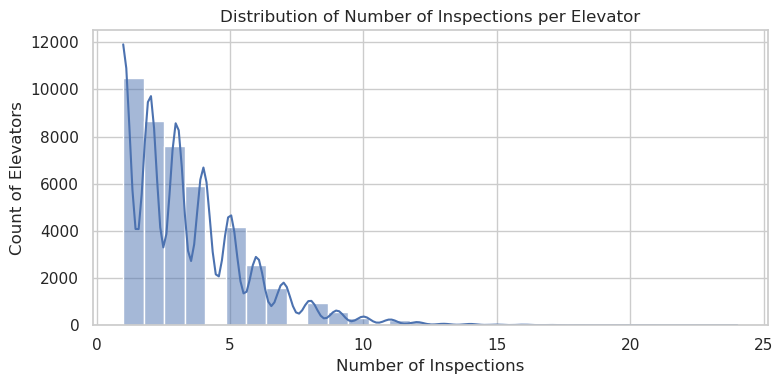


Elevators with 0 inspections: 0
Elevators with exactly 1 inspection: 10492


In [33]:

# Basic Stats
min_inspections = inspection_counts.min()
max_inspections = inspection_counts.max()
print(f"Minimum number of inspections for any elevator: {min_inspections}")
print(f"Maximum number of inspections for any elevator: {max_inspections}")

# Plotting a histogram
plt.figure(figsize=(8, 4))
sns.histplot(inspection_counts, bins=30, kde=True)
plt.title("Distribution of Number of Inspections per Elevator")
plt.xlabel("Number of Inspections")
plt.ylabel("Count of Elevators")
plt.tight_layout()
plt.show()

# Another optional insight: how many elevators have 0 or 1 inspection
zero_inspections = (inspection_counts == 0).sum()  # If there's a possibility of 0
one_inspection  = (inspection_counts == 1).sum()
print(f"\nElevators with 0 inspections: {zero_inspections}")
print(f"Elevators with exactly 1 inspection: {one_inspection}")




**Interpretation of Inspection Distribution**

> From the histogram and descriptive counts, we see a **large concentration** of elevators with only **one to four** inspection visits. Specifically:
> - ~10,000 elevators show exactly **1** inspection record,  
> - ~8,500 have **2** inspections,  
> - ~7,500 have **3**, and  
> - ~6,000 have **4**.  

> Beyond that, the number of elevators drops steadily:
> - ~4,000 have 5–6 inspections,  
> - ~2,500 have 6–7,  
> - ~1,800 have about 7, etc.  
> - Only a small tail extends above 10 inspections.

In other words, **most** elevators fall in the 1–4 range of inspections. This could imply several possibilities:

1. **Many relatively new or rarely inspected** elevators (if the dataset spans a short time window),  
2. **Data coverage** might be partial (not all historical inspections present), or  
3. **Typical** building codes that require periodic inspections only once or twice per year, with older or intensively used elevators having more frequent visits.

This kind of distribution often arises in scenarios where the majority of items (in this case, elevators) follow a standard, regulated pattern (1–2 scheduled inspections a year), while a smaller subset (with heavier usage or more compliance issues) accumulates higher inspection counts. Overall, the histogram confirms the skewed nature of inspection frequency, emphasizing that **most elevators** cluster around **low** inspection counts, with only a few reaching **10+**.

---

This textual **interpretation** helps stakeholders see at-a-glance what the pattern means and can open discussions about potential outliers (those with extremely high counts), or whether the data misses older historical inspections for some elevators.